dataset source: https://github.com/speechbrain/speechbrain/tree/develop/recipes/CommonLanguage

In [ ]:
import os
import time
import numpy as np
import pandas as pd
from concurrent.futures import ThreadPoolExecutor
import librosa
import librosa.display
import matplotlib.pyplot as plt
from IPython.display import Audio
import warnings

In [ ]:
warnings.filterwarnings('ignore')

In [ ]:
# audio path
dataset_path = '/kaggle/input/common-language/CommonLanguage/common_voice_kpd'

### Fungsi visualized_audio, ektraksi fitur, trim_audio, load_data

In [ ]:
# Function to visualize audio data in subplots
def visualize_audio(audio_data, sample_rate):
    try:
        fig, axs = plt.subplots(5, 1, figsize=(12, 15))

        # Plot waveplot
        librosa.display.waveshow(audio_data, sr=sample_rate, ax=axs[0])
        axs[0].set(title='Waveplot')

        # Plot mel-spectrogram
        mel_spect = librosa.feature.melspectrogram(y=audio_data, sr=sample_rate, n_mels=128)
        mel_spect_db = librosa.power_to_db(mel_spect, ref=np.max)
        img = librosa.display.specshow(mel_spect_db, sr=sample_rate, x_axis='time', y_axis='mel', ax=axs[1])
        fig.colorbar(img, ax=axs[1], format='%+2.0f dB')
        axs[1].set(title='Mel-Spectrogram')

        # Plot chroma feature
        stft = np.abs(librosa.stft(audio_data))
        chroma = librosa.feature.chroma_stft(S=stft, sr=sample_rate)
        img = librosa.display.specshow(chroma, sr=sample_rate, x_axis='time', y_axis='chroma', ax=axs[2])
        fig.colorbar(img, ax=axs[2])
        axs[2].set(title='Chroma Feature')

        # Plot spectral contrast
        spectral_contrast = librosa.feature.spectral_contrast(S=stft, sr=sample_rate)
        img = librosa.display.specshow(spectral_contrast, sr=sample_rate, x_axis='time', ax=axs[3])
        fig.colorbar(img, ax=axs[3])
        axs[3].set(title='Spectral Contrast')

        # Plot tonnetz feature
        harmonic = librosa.effects.harmonic(audio_data)
        tonnetz = librosa.feature.tonnetz(y=harmonic, sr=sample_rate)
        img = librosa.display.specshow(tonnetz, sr=sample_rate, x_axis='time', ax=axs[4])
        fig.colorbar(img, ax=axs[4])
        axs[4].set(title='Tonnetz')

        plt.tight_layout()
        plt.show()
    except Exception as e:
        print(f"Error encountered while parsing audio data. Error message: {str(e)}")

In [ ]:
# Function to load audio data
def load_audio(file_path):
    try:
        audio_data, sample_rate = librosa.load(file_path, sr=None)
        return audio_data, sample_rate
    except Exception as e:
        print(f"Error processing file {file_path}: {e}")
        return None, None

# Function to load audio data with multithreading
def load_audio_multithreaded(dataset_path):
    audio_list = []
    labels = []

    def process_folder(folder_path, label):
        if os.path.isdir(folder_path):
            for subfolder in os.listdir(folder_path):
                subfolder_path = os.path.join(folder_path, subfolder)
                if os.path.isdir(subfolder_path):
                    for file in os.listdir(subfolder_path):
                        file_path = os.path.join(subfolder_path, file)
                        if file_path.endswith(".wav"):
                            futures.append(executor.submit(load_audio, file_path))
                            labels.append(label)

    with ThreadPoolExecutor(max_workers=4) as executor:
        futures = []
        start_time = time.time()
        for language_folder in os.listdir(dataset_path):
            language_folder_path = os.path.join(dataset_path, language_folder)
            if os.path.isdir(language_folder_path):
                train_path = os.path.join(language_folder_path, 'train')
                test_path = os.path.join(language_folder_path, 'test')
                val_path = os.path.join(language_folder_path, 'dev')

                # Process files in train, test, and dev folders
                process_folder(train_path, language_folder)
                process_folder(test_path, language_folder)
                process_folder(val_path, language_folder)

        # Retrieve results from futures
        for future in futures:
            audio_data, sample_rate = future.result()
            if audio_data is not None:
                audio_list.append((audio_data, sample_rate))

        end_time = time.time()
        print(f"Total time taken to load audio data: {end_time - start_time:.2f} seconds")

    return audio_list, labels

### Load audio file

In [ ]:
# Load audio data without trimming
audio_list, labels = load_audio_multithreaded(dataset_path)

Total time taken to load audio data: 92.09 seconds


In [ ]:
print(f"Loaded {len(audio_list)} audio samples with {len(set(labels))} unique labels.")

Loaded 34047 audio samples with 45 unique labels.


In [ ]:
# Menghitung jumlah unique labels
unique_labels = np.unique(labels)
num_unique_labels = len(unique_labels)

print(f"Unique labels: {unique_labels}")
print(f"Number of unique labels: {num_unique_labels}")

Unique labels: ['Arabic' 'Basque' 'Breton' 'Catalan' 'Chinese_China' 'Chinese_Hongkong'
 'Chinese_Taiwan' 'Chuvash' 'Czech' 'Dhivehi' 'Dutch' 'English'
 'Esperanto' 'Estonian' 'French' 'Frisian' 'Georgian' 'German' 'Greek'
 'Hakha_Chin' 'Indonesian' 'Interlingua' 'Italian' 'Japanese' 'Kabyle'
 'Kinyarwanda' 'Kyrgyz' 'Latvian' 'Maltese' 'Mangolian' 'Persian' 'Polish'
 'Portuguese' 'Romanian' 'Romansh_Sursilvan' 'Russian' 'Sakha' 'Slovenian'
 'Spanish' 'Swedish' 'Tamil' 'Tatar' 'Turkish' 'Ukranian' 'Welsh']
Number of unique labels: 45


### Contoh audio

In [ ]:
audio_data, sample_rate = audio_list[0]

Audio(audio_data, rate=sample_rate)

### Contoh visualisasi audio

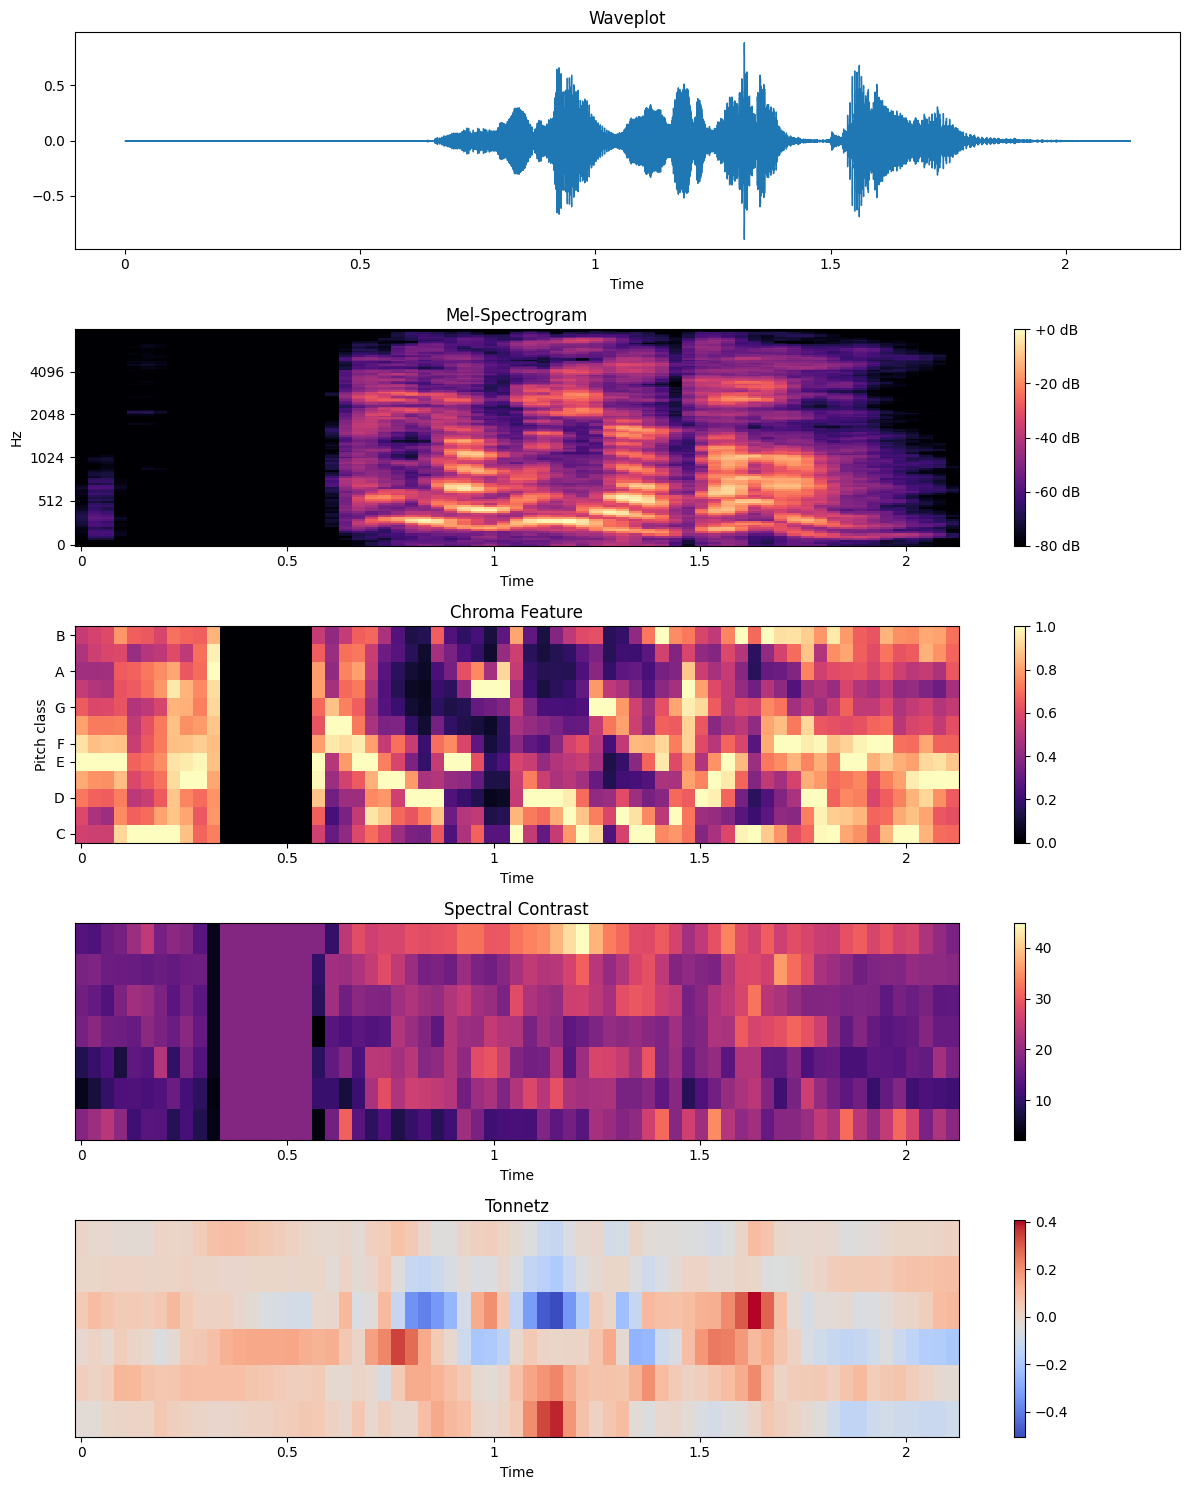

In [ ]:
visualize_audio(audio_data, sample_rate)

## Clean audio

#### trimming bagian awal/akhir

In [ ]:
import torchaudio
import torch
import numpy as np
import torchaudio.functional as F

In [ ]:
def trim_silence(audio_data, sample_rate, threshold_db=-40.0, frame_length=1024, hop_length=256):
    # Convert to tensor if not already
    if not isinstance(audio_data, torch.Tensor):
        audio_data = torch.tensor(audio_data)

    # Ensure audio is 2D (channels, samples)
    if audio_data.dim() == 1:
        audio_data = audio_data.unsqueeze(0)

    # Calculate energy of each frame
    energy = audio_data.pow(2).mean(dim=0)

    # Convert energy to decibels
    db = 10 * torch.log10(energy + 1e-10)  # Add small value to avoid log(0)

    # Find frames where energy is above the threshold
    mask = db > threshold_db

    # Find start and end samples
    start_sample = 0
    while start_sample < mask.size(0) and not mask[start_sample]:
        start_sample += 1

    end_sample = mask.size(0) - 1
    while end_sample > 0 and not mask[end_sample]:
        end_sample -= 1

    # Return trimmed audio
    return audio_data[:, start_sample:end_sample + 1], sample_rate

In [ ]:
def trim_all_audio(audio_list):
    trimmed_audio_list = []
    for audio_data, sample_rate in audio_list:
        trimmed_waveform, _ = trim_silence(audio_data, sample_rate)
        trimmed_audio_list.append((trimmed_waveform, sample_rate))
    return trimmed_audio_list

In [ ]:
# Lakukan trimming
trimmed_audio_list = trim_all_audio(audio_list)

In [ ]:
# Periksa hasil trimming
if trimmed_audio_list:
    for i in range(min(5, len(trimmed_audio_list))):
        original_audio, sample_rate = audio_list[i]
        trimmed_audio, _ = trimmed_audio_list[i]
        print(f"Audio {i+1}:")

        # Menangani berbagai tipe data untuk original_audio
        if isinstance(original_audio, list):
            original_length = len(original_audio)
        elif isinstance(original_audio, (torch.Tensor, np.ndarray)):
            original_length = original_audio.shape[-1]  # Mengambil dimensi terakhir
        elif isinstance(original_audio, int):
            original_length = original_audio
        else:
            original_length = len(original_audio)  # Mencoba len() untuk tipe lainnya

        # Menangani berbagai tipe data untuk trimmed_audio
        if isinstance(trimmed_audio, (torch.Tensor, np.ndarray)):
            trimmed_length = trimmed_audio.shape[-1]
        elif isinstance(trimmed_audio, int):
            trimmed_length = trimmed_audio
        else:
            trimmed_length = len(trimmed_audio)  # Mencoba len() untuk tipe lainnya

        print(f"  Original length: {original_length} samples")
        print(f"  Trimmed length: {trimmed_length} samples")

        # Menghitung pengurangan
        if original_length > 0:
            reduction = 100 * (1 - trimmed_length / original_length)
            print(f"  Reduction: {reduction:.2f}%")
        else:
            print("  Reduction: N/A (original length is 0)")

    print(f"Sample rate: {sample_rate}")
else:
    print("No audio data found.")

Audio 1:
  Original length: 34176 samples
  Trimmed length: 20235 samples
  Reduction: 40.79%
Audio 2:
  Original length: 30336 samples
  Trimmed length: 13458 samples
  Reduction: 55.64%
Audio 3:
  Original length: 56064 samples
  Trimmed length: 24717 samples
  Reduction: 55.91%
Audio 4:
  Original length: 43776 samples
  Trimmed length: 32597 samples
  Reduction: 25.54%
Audio 5:
  Original length: 75264 samples
  Trimmed length: 65756 samples
  Reduction: 12.63%
Sample rate: 16000


In [ ]:
trimaudio_data, trimsample_rate = trimmed_audio_list[0]

Audio(trimaudio_data, rate=trimsample_rate)

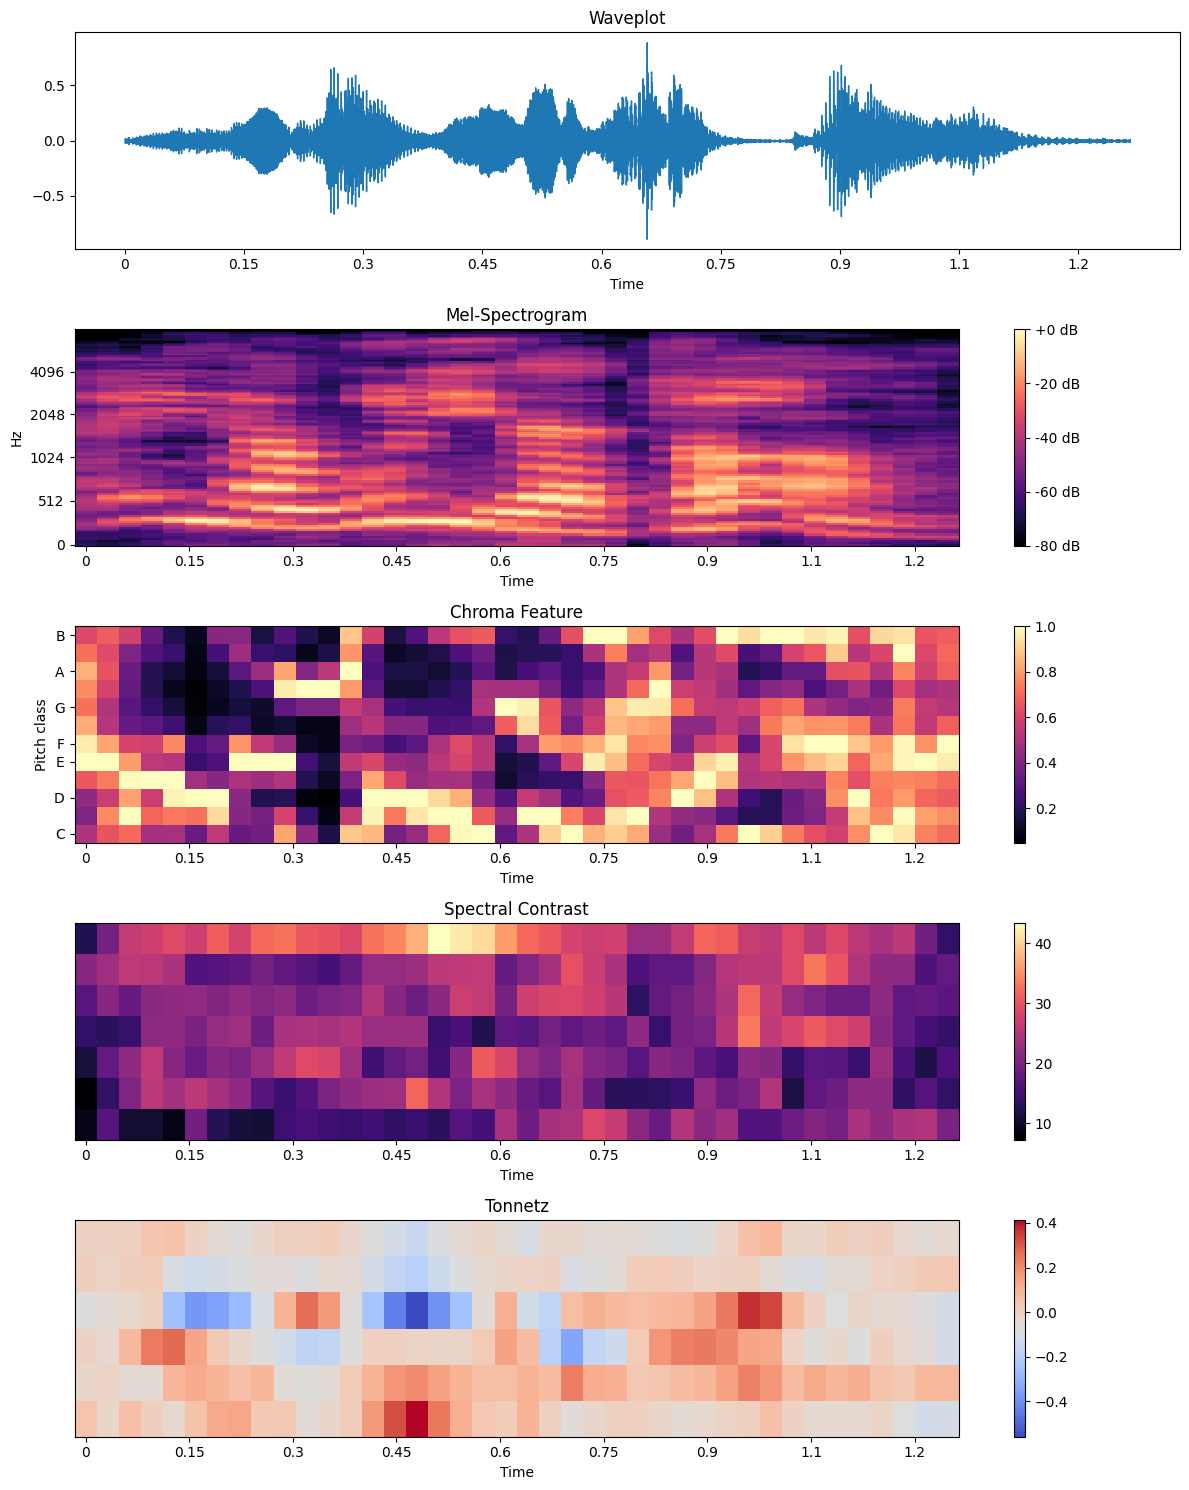

In [ ]:
# Function to visualize audio data in subplots
def visualize_audio(audio_data, sample_rate):
    try:
        # Convert audio data to numpy array if it's not already
        if isinstance(audio_data, torch.Tensor):
            audio_data = audio_data.numpy()
        elif not isinstance(audio_data, np.ndarray):
            audio_data = np.array(audio_data)

        # Ensure audio data is 1D
        if audio_data.ndim > 1:
            audio_data = audio_data.flatten()

        fig, axs = plt.subplots(5, 1, figsize=(12, 15))

        # Plot waveplot
        librosa.display.waveshow(audio_data, sr=sample_rate, ax=axs[0])
        axs[0].set(title='Waveplot')

        # Plot mel-spectrogram
        mel_spect = librosa.feature.melspectrogram(y=audio_data, sr=sample_rate, n_mels=128)
        mel_spect_db = librosa.power_to_db(mel_spect, ref=np.max)
        img = librosa.display.specshow(mel_spect_db, sr=sample_rate, x_axis='time', y_axis='mel', ax=axs[1])
        fig.colorbar(img, ax=axs[1], format='%+2.0f dB')
        axs[1].set(title='Mel-Spectrogram')

        # Plot chroma feature
        stft = np.abs(librosa.stft(audio_data))
        chroma = librosa.feature.chroma_stft(S=stft, sr=sample_rate)
        img = librosa.display.specshow(chroma, sr=sample_rate, x_axis='time', y_axis='chroma', ax=axs[2])
        fig.colorbar(img, ax=axs[2])
        axs[2].set(title='Chroma Feature')

        # Plot spectral contrast
        spectral_contrast = librosa.feature.spectral_contrast(S=stft, sr=sample_rate)
        img = librosa.display.specshow(spectral_contrast, sr=sample_rate, x_axis='time', ax=axs[3])
        fig.colorbar(img, ax=axs[3])
        axs[3].set(title='Spectral Contrast')

        # Plot tonnetz feature
        harmonic = librosa.effects.harmonic(audio_data)
        tonnetz = librosa.feature.tonnetz(y=harmonic, sr=sample_rate)
        img = librosa.display.specshow(tonnetz, sr=sample_rate, x_axis='time', ax=axs[4])
        fig.colorbar(img, ax=axs[4])
        axs[4].set(title='Tonnetz')

        plt.tight_layout()
        plt.show()
    except Exception as e:
        print(f"Error encountered while parsing audio data. Error message: {str(e)}")

# Menggunakan fungsi
visualize_audio(trimaudio_data, trimsample_rate)

#### Normalisasi Audio

Penjelasan fungsi normalize_audio:

Fungsi ini mengambil input audio dan target dBFS (decibels relative to full scale).

Menghitung RMS (Root Mean Square) dari audio untuk mendapatkan level rata-rata.

Menghitung dBFS saat ini berdasarkan RMS.

Menghitung faktor gain yang diperlukan untuk mencapai target dBFS.

Menerapkan gain ke audio.

Melakukan clipping untuk memastikan bahwa tidak ada sampel yang melebihi rentang [-1, 1].

Fungsi normalize_all_audio menerapkan normalisasi ke semua file audio dalam list.


Keuntungan dari pendekatan ini:

Konsistensi volume: Semua file audio akan memiliki level suara yang konsisten, yang penting untuk klasifikasi.

Preservasi karakteristik spektral: Metode ini mempertahankan karakteristik frekuensi relatif dalam sinyal, yang penting untuk identifikasi bahasa.

Pencegahan clipping: Dengan melakukan clipping pada [-1, 1], kita mencegah distorsi yang tidak diinginkan.

Fleksibilitas: Target dBFS dapat disesuaikan berdasarkan kebutuhan spesifik dataset Anda.

In [ ]:
def normalize_audio(audio_data, target_dBFS=-20):
    """
    Normalize the audio to a target dB Full Scale (dBFS) level.

    :param audio_data: Audio tensor (channels, samples)
    :param target_dBFS: Target dB Full Scale level
    :return: Normalized audio tensor
    """
    if not isinstance(audio_data, torch.Tensor):
        audio_data = torch.tensor(audio_data)

    # Ensure audio is 2D (channels, samples)
    if audio_data.dim() == 1:
        audio_data = audio_data.unsqueeze(0)

    # Calculate current RMS
    rms = torch.sqrt(torch.mean(audio_data**2))

    # Calculate current dBFS
    current_dBFS = 20 * torch.log10(rms)

    # Calculate the gain factor
    gain_factor = 10**((target_dBFS - current_dBFS) / 20)

    # Apply the gain
    normalized_audio = audio_data * gain_factor

    # Clip to ensure no samples exceed [-1, 1]
    normalized_audio = torch.clamp(normalized_audio, -1, 1)

    return normalized_audio

def normalize_all_audio(audio_list, target_dBFS=-20):
    normalized_audio_list = []
    for audio_data, sample_rate in audio_list:
        normalized_audio = normalize_audio(audio_data, target_dBFS)
        normalized_audio_list.append((normalized_audio, sample_rate))
    return normalized_audio_list

In [ ]:
normalized_audio_list = normalize_all_audio(trimmed_audio_list)

In [ ]:
normaudio_data, normsample_rate = normalized_audio_list[0]

Audio(normaudio_data, rate=normsample_rate)

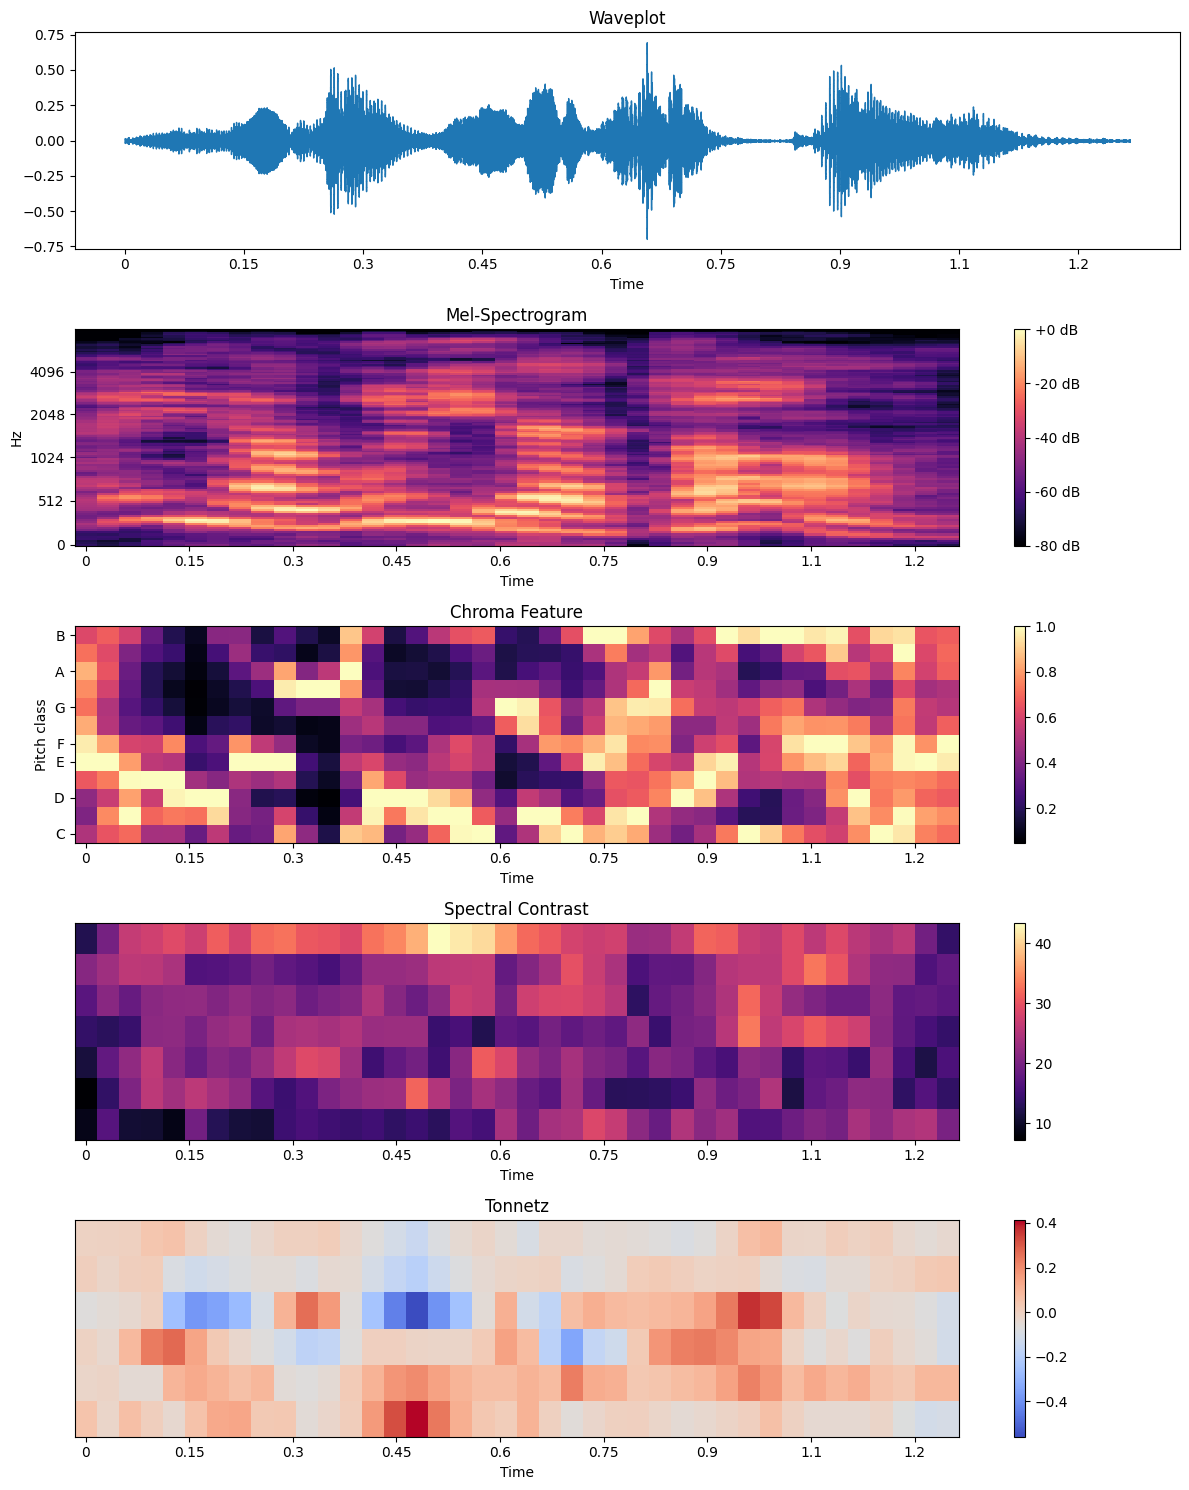

In [ ]:
visualize_audio(normaudio_data, normsample_rate)

tidak dilakukan segmentasi karena mungkin bisa menghilangkan konteks penting yang mungkin ada dalam rekaman

setiap sampel juga tidak terlalu panjang

### Augmentasi Data Audio

Pitch shifting:

Kegunaan: Mengubah pitch audio tanpa mengubah durasi.

Relevansi untuk SLI: Cukup berguna karena membantu model beradaptasi dengan variasi pitch antar pembicara. Namun, harus digunakan dengan hati-hati karena perubahan pitch yang terlalu ekstrem bisa mengubah karakteristik bahasa.

Adding background noise:

Kegunaan: Menambahkan noise latar belakang ke audio untuk mensimulasikan kondisi perekaman yang berbeda-beda.

Relevansi untuk SLI: Sangat berguna karena meningkatkan robustness model terhadap kondisi perekaman yang berbeda-beda. Ini penting karena dalam aplikasi nyata, audio bisa direkam dalam berbagai kondisi lingkungan.

Speed perturbation:

Kegunaan: Mengubah kecepatan audio, yang mempengaruhi baik durasi maupun pitch.

Relevansi untuk SLI: Berguna karena menggabungkan efek perubahan kecepatan dan pitch. Ini bisa membantu model belajar fitur-fitur bahasa yang invarian terhadap variasi kecepatan dan pitch secara bersamaan.

#### Time scretching

Kegunaan: Memperpanjang atau mempersingkat durasi audio tanpa mengubah pitch.

Relevansi untuk SLI: Sangat berguna karena membantu model belajar invariansi terhadap kecepatan bicara yang berbeda-beda. Ini penting karena kecepatan bicara bisa bervariasi antar pembicara dan bahasa.

In [ ]:
def time_stretch(audio, rate):
    """
    Apply time stretching to the audio.

    :param audio: Audio tensor (channels, samples)
    :param rate: Stretching rate. If rate > 1, slow down; if rate < 1, speed up
    :return: Time-stretched audio tensor
    """
    if isinstance(audio, torch.Tensor):
        audio = audio.numpy()

    # Ensure audio is 2D (channels, samples)
    if audio.ndim == 1:
        audio = audio[np.newaxis, :]

    stretched = librosa.effects.time_stretch(audio[0], rate=rate)
    return torch.tensor(stretched[np.newaxis, :])

In [ ]:
def add_background_noise(audio, noise_level=0.005):
    """
    Add background noise to the audio.

    :param audio: Audio tensor (channels, samples)
    :param noise_level: Level of noise to add (default: 0.005)
    :return: Audio tensor with added noise
    """
    if not isinstance(audio, torch.Tensor):
        audio = torch.tensor(audio)

    # Ensure audio is 2D (channels, samples)
    if audio.dim() == 1:
        audio = audio.unsqueeze(0)

    noise = torch.randn_like(audio) * noise_level
    return audio + noise

In [ ]:
def augment_audio(audio_list, augmentation_factor=2):
    """
    Augment the audio data with time stretching and background noise.

    :param audio_list: List of (audio, sample_rate) tuples
    :param augmentation_factor: Number of augmented versions to create for each audio
    :return: List of augmented (audio, sample_rate) tuples
    """
    augmented_audio_list = []

    for audio, sample_rate in audio_list:
        augmented_audio_list.append((audio, sample_rate))  # Original audio

        for _ in range(augmentation_factor):
            # Time stretching
            stretch_rate = np.random.uniform(0.9, 1.1)  # Random rate between 0.9 and 1.1
            stretched_audio = time_stretch(audio, stretch_rate)

            # Add background noise
            noisy_audio = add_background_noise(stretched_audio)

            augmented_audio_list.append((noisy_audio, sample_rate))

    return augmented_audio_list

In [ ]:
augmented_audio_list = augment_audio(normalized_audio_list)

In [ ]:
augaudio_data, augsample_rate = augmented_audio_list[0]

Audio(augaudio_data, rate=augsample_rate)

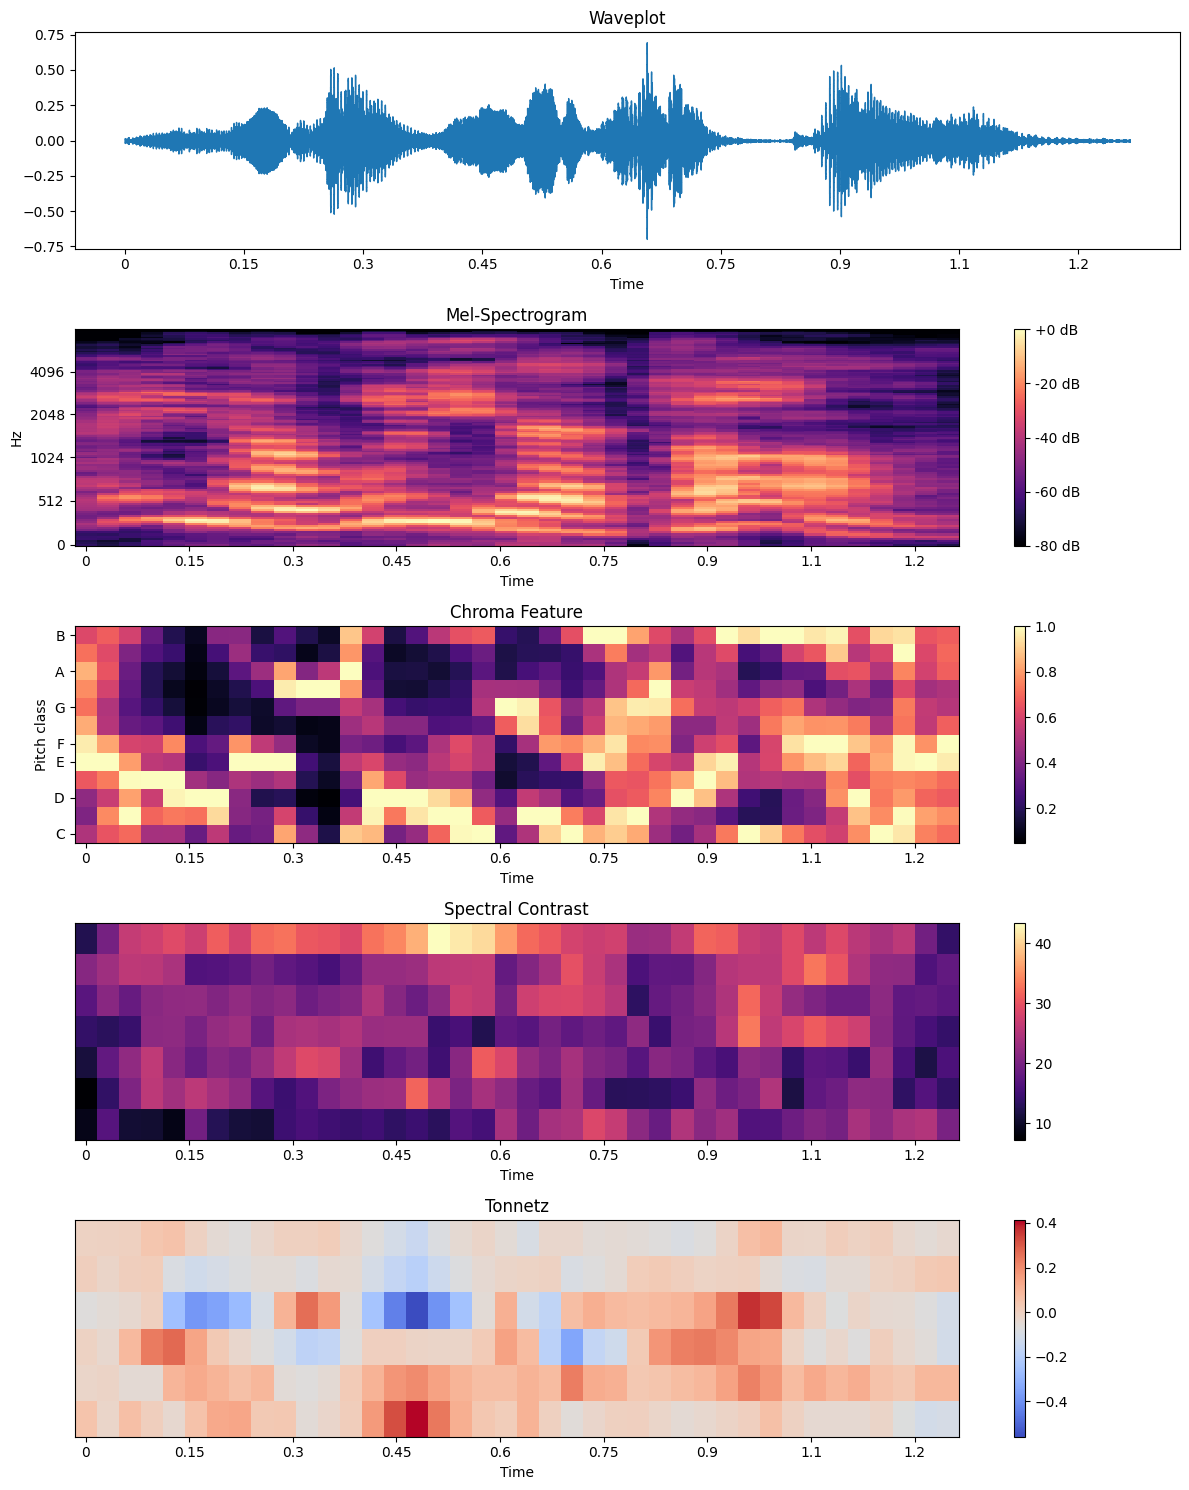

In [ ]:
visualize_audio(augaudio_data, augsample_rate)

In [ ]:
from scipy.io import wavfile

def save_processed_audio(augmented_audio_list, labels, output_path):
    os.makedirs(output_path, exist_ok=True)

    for idx, (audio, sample_rate) in enumerate(augmented_audio_list):
        original_idx = idx // (augmentation_factor + 1)
        label = labels[original_idx]

        label_folder = os.path.join(output_path, label)
        os.makedirs(label_folder, exist_ok=True)

        file_name = f"{label}_{idx}.wav"
        file_path = os.path.join(label_folder, file_name)

        if isinstance(audio, torch.Tensor):
            audio = audio.detach().cpu().numpy()

        sample_rate = int(sample_rate)

        # Normalize to 16-bit integer values
        audio = np.int16(audio * 32767)

        if audio.ndim == 1:
            audio = audio.reshape(1, -1)
        elif audio.ndim > 2:
            audio = audio.squeeze()
            if audio.ndim > 2:
                print(f"Skipping audio with shape {audio.shape}")
                continue

        if audio.shape[0] > audio.shape[1]:
            audio = audio.T

        try:
            wavfile.write(file_path, sample_rate, audio.T)
        except Exception as e:
            print(f"Error saving {file_path}: {str(e)}")
            print(f"Audio shape: {audio.shape}, dtype: {audio.dtype}, sample rate: {sample_rate}")
            continue

    print(f"Semua file audio telah disimpan di {output_path}")

# Simpan audio yang telah diproses
output_path = "processed_audio_dataset"
save_processed_audio(augmented_audio_list, labels, output_path)

Semua file audio telah disimpan di processed_audio_dataset
